# A Dual Latent Space Model for Physical Flow Parameter Estimation from Fiber Optic Sensing Data

### Misael M. Morales, Carlos Torres-Verdin, Michael J. Pyrcz, (+ Lytt)

In [1]:
from utils import *

check_tf()
K.clear_session()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Utility Functions:
1. check_tf() - ensure that tensorflow is built with GPU support
2. my_normalize() - mnual MinMax or MaxAbs normalization
3. plot_loss() - plot keras training performance
4. plot_relative_rates() - plot 4-phase, 5-location relative rates [for all experiments]
5. plot_relative_mat() - plot 4-phase, 200-location relative rates [for all experiments]
6. plot_das_dts_flow() - visualize DAS, DTS, and Flow data
7. plot_latent() - visualize latent space (combined) feature map
8. plot_featuremaps() - visualize (individual) feature maps
9. plot_true_pred_z() - plot true and predicted DAS/DTS along with (combined) latent feature map
10. plot_rates_true_pred() - visualize true and predicted (from z) relative rates and locations
11. mse_ssim_loss() - tensorflow dual mse-ssim loss function
12. mse_mae_loss() - tensorflow dual mse-mae loss function
13. das_Unet() - make DAS autoencoder
14. dts_Unet() - make DTS autoencoder
15. make_flowpred_from_dual_latent() - make relative flowrate and injection location estimation from dual latent space
16. transfer_learning_predictions() - make predictions for new DAS/DTS/Flow data after pre-training autoencoders with another dataset


***

Open Raw DAS/DTS files and save as pandas pickles
 - crop fiber data into 200m segment, corresponding to the length of the flowloop [4950, 5150]

In [2]:
# def read_save_dts_data(folder, save_name, size=200):
#     print('This is Experiment {}. Saved.'.format(folder[-2:]))
#     ### folder1 == 'E:/Research/Lytt Fiber Optics/DTS Experiment 54' ###
#     ### folder2 == 'E:/Research/Lytt Fiber Optics/DTS Experiment 64' ###
#     # save depth datums
#     dts_depths = pd.read_csv(os.path.join(folder, os.listdir(folder)[0]), usecols=[1]).squeeze()[-size:]
#     dts_depths.to_pickle('dts_depthstamps.pkl')
#     # save timestamps
#     dts_timestamps = pd.Series(dtype='object')
#     for i in range(len(os.listdir(folder))):
#         dts_timestamps.loc[i] = pd.to_datetime(os.listdir(folder)[i][9:19], format="%H%M%S%f").time()
#     if folder[-2:]=='54':
#         dts_timestamps.to_pickle('dts_exp54_timestamps.pkl')    
#     elif folder[-2:]=='64':
#         dts_timestamps.to_pickle('dts_exp64_timestamps.pkl')
#     # save temperature data
#     all_files  = os.listdir(folder)
#     dts_df = pd.DataFrame(())
#     for i in range(len(all_files)):
#         my_file = os.listdir(folder)[i]
#         file_path = os.path.join(folder, my_file)
#         new_dts   = pd.read_csv(file_path, usecols=[2])
#         dts_df = pd.concat([dts_df, new_dts], ignore_index=True, axis=1)
#     dts_postprocess = dts_df.iloc[-size:]
#     dts_postprocess.to_pickle(save_name)

# # Function to open H5 file as Pandas DataFrame
# def open_fiber_H5_2_arr(folder_n=1, file_n=0, xstart=4950, xend=5150):
#     if folder_n==1:
#         fold = 'E:/Lytt Fiber Optics/Sintef3mH5'
#     elif folder_n==2:
#         fold = 'E:/Lytt Fiber Optics/Sintef10mH5'
#     elif folder_n==45:
#         fold = 'E:/Lytt Fiber Optics/45'
#     elif folder_n==48:
#         fold = 'E:/Lytt Fiber Optics/48'
#     elif folder_n==109:
#         fold = 'E:/Lytt Fiber Optics/109'
#     elif folder_n==128:
#         fold = 'E:/Lytt Fiber Optics/128'
#     file = os.listdir(fold)
#     file_path = os.path.join(fold, file[file_n])
#     f = h5py.File(file_path, 'r')
#     df = pd.DataFrame((f['Acquisition']['Raw[0]']['RawData'])).iloc[:, xstart:xend].T
#     f.close
#     return df

# # change folder_i, files_i to desired experiment
# folder128 = 'E:/Lytt Fiber Optics/128'
# print('Experiment 128 (file128) # of files: {}'.format(len(os.listdir(folder128))))
# data_exp128 = pd.DataFrame(())
# for i in range(len(os.listdir(folder128))):
#     new_data1 = open_fiber_H5_2_arr(folder_n=128, file_n=i, xstart=4950, xend=5150)
#     data_exp128 = pd.concat([data_exp128, new_data1], ignore_index=True, axis=1)
#     data_exp128.to_pickle('E:/Lytt Fiber Optics/data_exp128.pkl')

Manually define flow matrices from file: SINTEF19_testmatrix.xlsx

- Background
- Gas calibration factor: m3/hr to cfd: =(35.3*24)
- Water Calibration factor from kg/s to bpd (=3.6/.0066)
- Oil calib factor for kg/s to bpd = ((3.6/.0066)/.782) for .782 oil density
- Oil calib factor for m3/hr to bpd = (1/.0066)

| (e.g., Exp 109) | Oil (bpd) | Gas (cfd) | Water (bpd) |   Sand    |
|       ---       |    ---    |    ---    |     ---     |    ---    |
| Background      |    6000   |    90000  |     0       |    0      |
| Injection 1     |    500    |    7500   |     0       |    0      |
| Injection 2     |    500    |    7500   |     0       |    0      |
| Injection 3     |    0      |    0      |     0       |    0      |
| Injection 4     |    0      |    0      |     500     |    10     |


In [3]:
exp45_flow = np.array([[1500, 0,    0, 0],
                        [250, 8250, 0, 0],
                        [250, 8250, 0, 0],
                        [0,   0,    0, 0],
                        [0,   0,    0, 0]])

exp48_flow = np.array([[3000,  0, 0,    0],
                        [500,  0, 0,    0],
                        [150,  0, 1500, 0],
                        [100,  0, 0,    0],
                        [5000, 0, 0,    0]])

exp54_flow = np.array([[1500, 50000,    0,    0],
                        [250, 8333.33,  1000, 0],
                        [250, 8333.33,  0,    0],
                        [0,   0,        0,    0],
                        [500, 16666.66, 1000, 0]])

exp64_flow = np.array([[3000, 100000,   0,    0],
                        [250, 8333.33,  250,  0],
                        [250, 8333.33,  100,  0],
                        [0,   0,        0,    0],
                        [250, 8333.33,  250,  0]])

exp109_flow = np.array([[6000, 90000,  0,   0],
                        [500,  7500,   0,   0],
                        [500,  7500,   0,   0],
                        [0,    0,      0,   0],
                        [0,    0,      500, 10]])

exp128_flow = np.array([[3000, 60000,  0,   0],
                        [500,  20000,  0,   0],
                        [500,  20000,  0,   0],
                        [0,    0,      0,   0],
                        [500,  20000,  0,   5]])

***

In [4]:
flow45_norm,  scaler45  = my_normalize(exp45_flow)
flow48_norm,  scaler48  = my_normalize(exp45_flow)
flow54_norm,  scaler54  = my_normalize(exp45_flow)
flow64_norm,  scaler64  = my_normalize(exp45_flow)
flow109_norm, scaler109 = my_normalize(exp109_flow)
flow128_norm, scaler128 = my_normalize(exp128_flow)

Original: (6, 5, 4) | Normalized: (6, 5, 4)


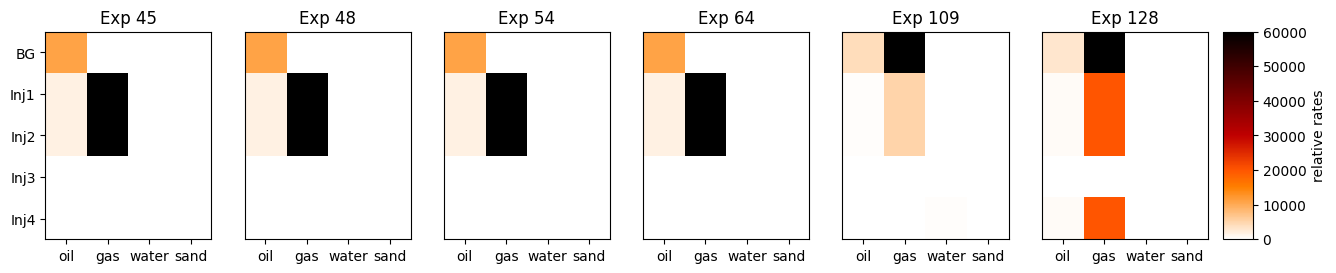

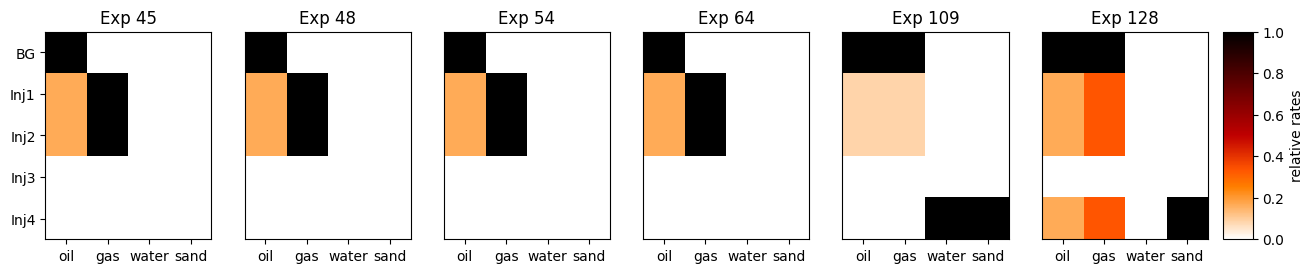

In [5]:
all_flow_orig = np.array([exp45_flow, exp45_flow, exp45_flow, exp45_flow, exp109_flow, exp128_flow])
all_flow_norm = np.array([flow45_norm, flow48_norm, flow54_norm, 
                          flow64_norm, flow109_norm, flow128_norm])

print('Original: {} | Normalized: {}'.format(all_flow_orig.shape, all_flow_norm.shape))
plot_relative_rates(all_flow_orig, cmap='gist_heat_r')
plot_relative_rates(all_flow_norm, cmap='gist_heat_r')

Individual Flow shapes: (200, 4) (200, 4) (200, 4) (200, 4) (200, 4) (200, 4)


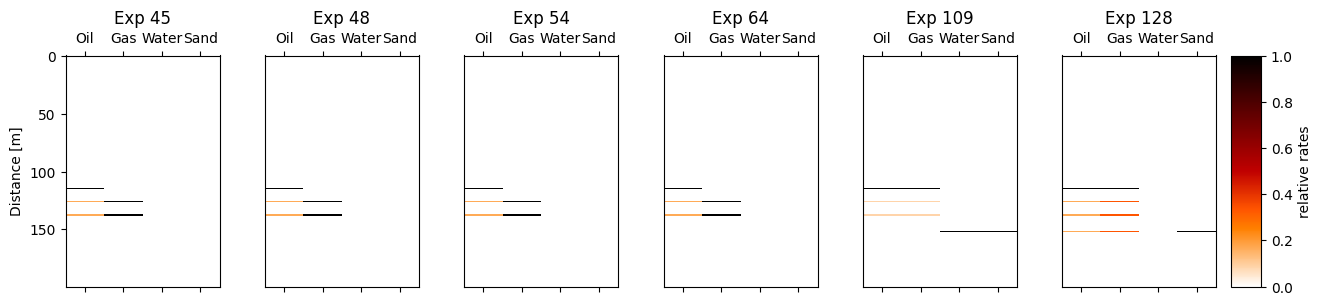

In [6]:
inj_idx = [115, 126, 138, 142, 152]

flow45  = make_sparse_flowrates(all_flow_norm[0], inj_idx)
flow48  = make_sparse_flowrates(all_flow_norm[1], inj_idx)
flow54  = make_sparse_flowrates(all_flow_norm[2], inj_idx)
flow64  = make_sparse_flowrates(all_flow_norm[3], inj_idx)
flow109 = make_sparse_flowrates(all_flow_norm[4], inj_idx)
flow128 = make_sparse_flowrates(all_flow_norm[5], inj_idx)
flow = np.array([flow45, flow48, flow54, flow64, flow109, flow128])
print('Individual Flow shapes:', flow45.shape, flow48.shape,  flow54.shape, 
                                 flow64.shape, flow109.shape, flow128.shape)
plot_relative_mat(flow, cmap='gist_heat_r')

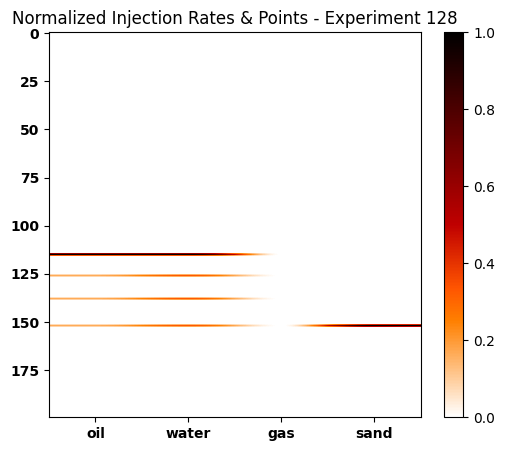

In [22]:
plt.figure(figsize=(6,5))
plt.imshow(flow128, aspect='auto', cmap='gist_heat_r')
plt.colorbar()
plt.xticks(np.arange(4), labels=['oil','water','gas','sand'], weight='bold')
plt.yticks(weight='bold')
plt.title('Normalized Injection Rates & Points - Experiment {}'.format(128))
plt.show()

In [7]:
das45,  dts45  = make_daslhs_dts('45')
das48,  dts48  = make_daslhs_dts('48')
das54,  dts54  = make_daslhs_dts('54')
das64,  dts64  = make_daslhs_dts('64')
das109, dts109 = make_daslhs_dts('109')
das128, dts128 = make_daslhs_dts('128')

print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

KeyboardInterrupt: 

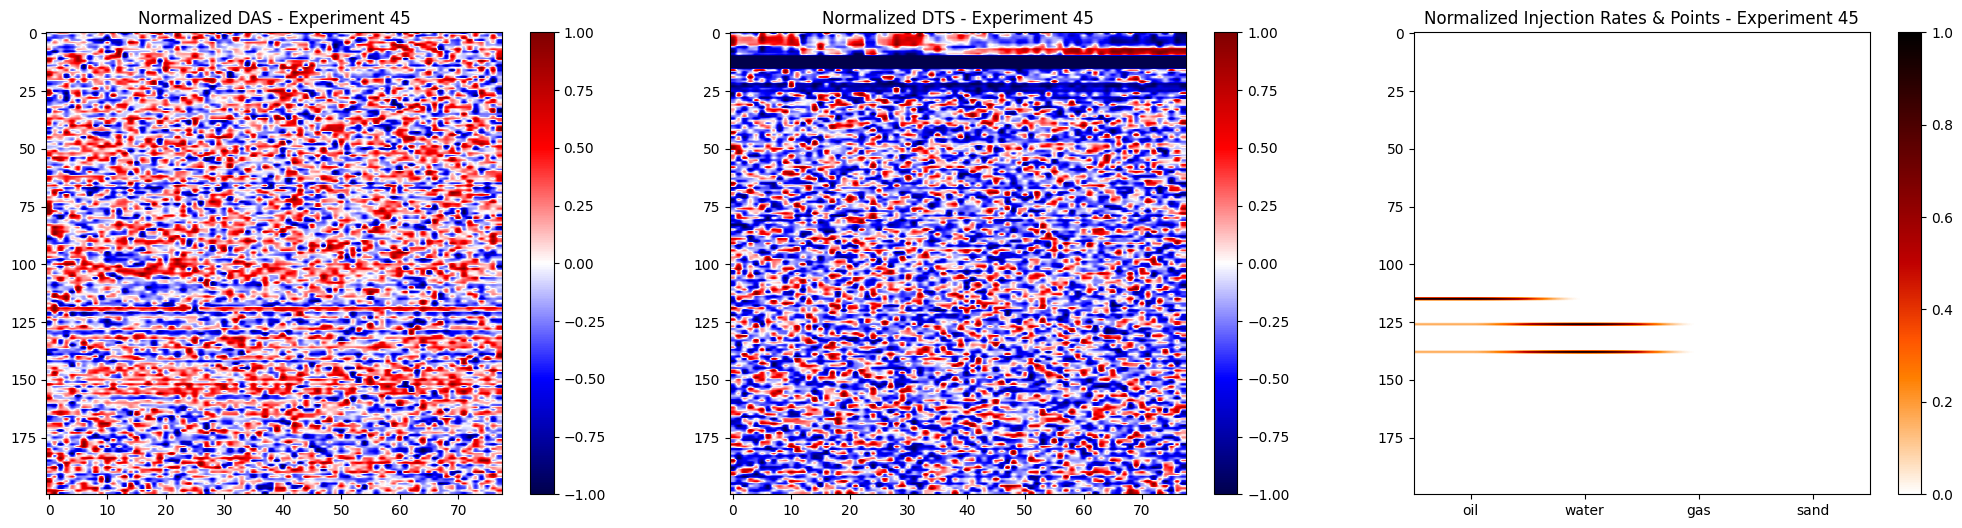

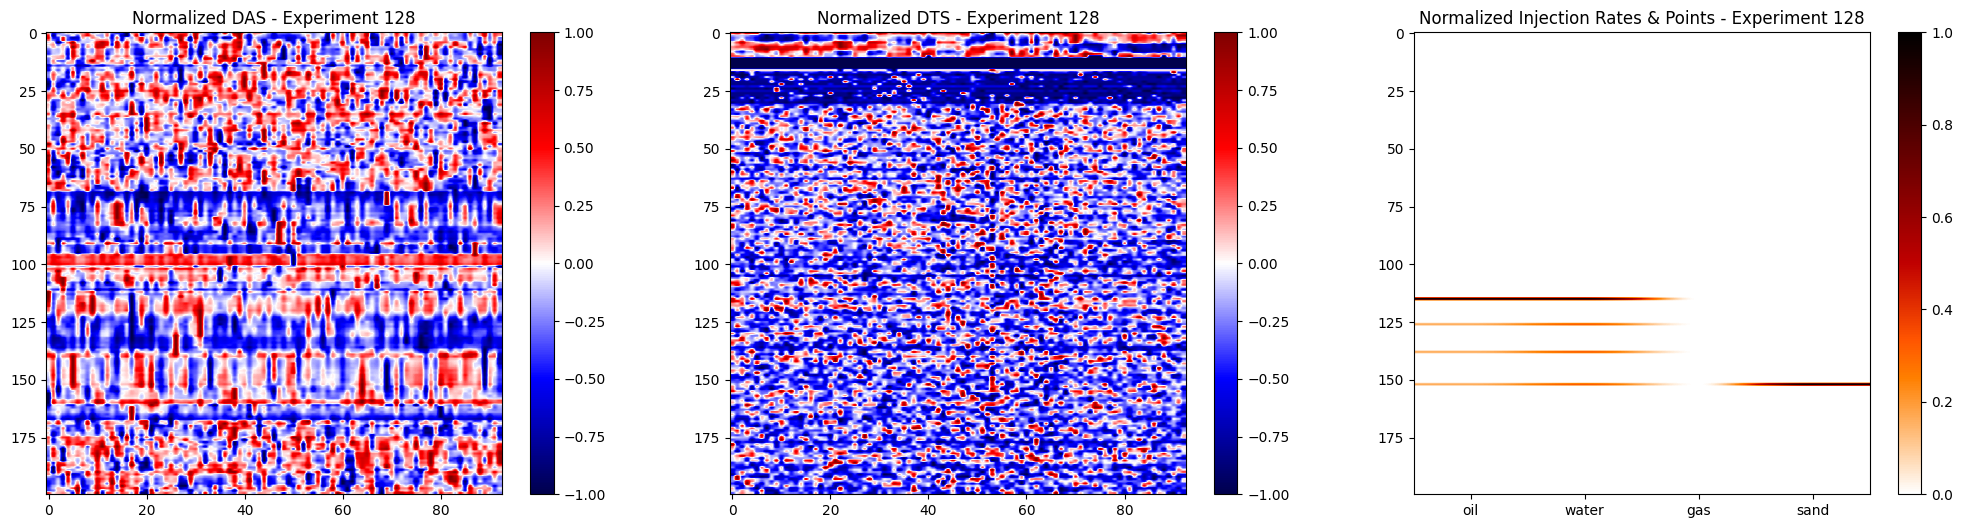

In [ ]:
plot_das_dts_flow(das45,  dts45,  flow45,  expnum='45')
plot_das_dts_flow(das128, dts128, flow128, expnum='128')

***

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220
3/3 [==============================] - 0s 3ms/step
SSIM = 90.76
MSE  = 4.604e-03
PSNR = 29.39


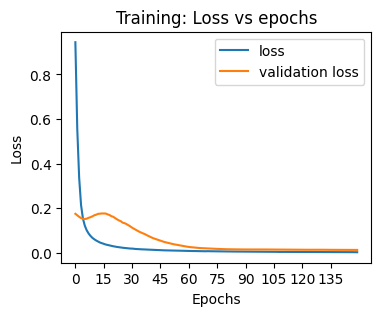

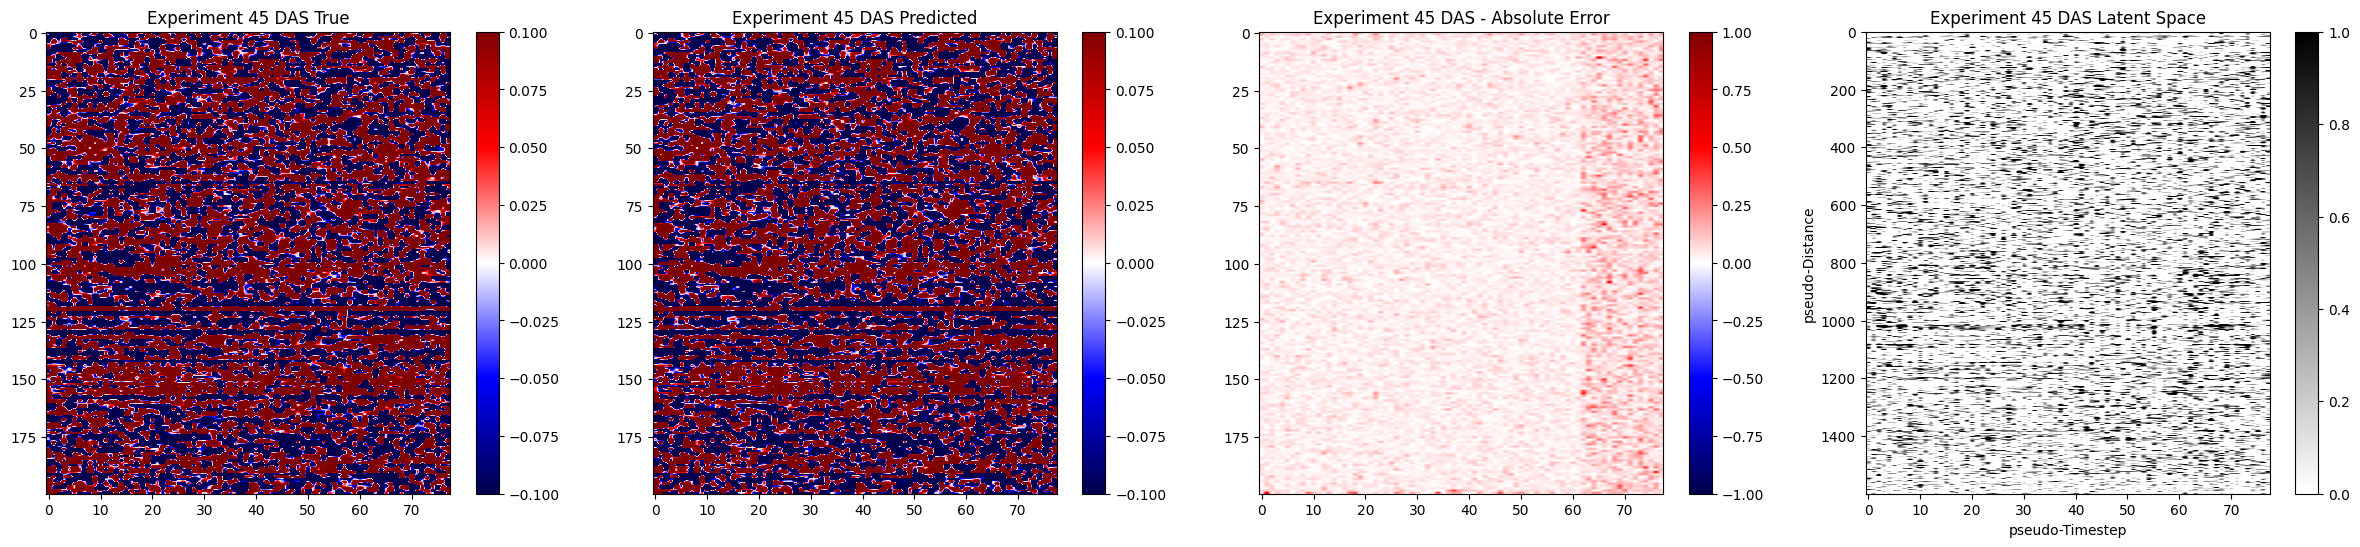

In [14]:
das_m2m, das_m2z = das_Unet()
print('AutoEncoder # of parameters: {:,}'.format(das_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(das_m2z.count_params()))

das_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_das = das_m2m.fit(das45, das45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_das, figsize=(4,3))

das45_pred = das_m2m.predict(das45).squeeze().astype('float64')
das45_z = das_m2z.predict(das45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(das45.squeeze().T, das45_pred.T)))
print('MSE  = {:.3e}'.format(image_mse(das45.squeeze().T, das45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(das45.squeeze().T, das45_pred.T, data_range=2)))

plot_true_pred_z(das45, das45_pred, das45_z, filenum='45 DAS')

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220
3/3 [==============================] - 0s 3ms/step
SSIM = 96.39
MSE  = 5.863e-03
PSNR = 28.34


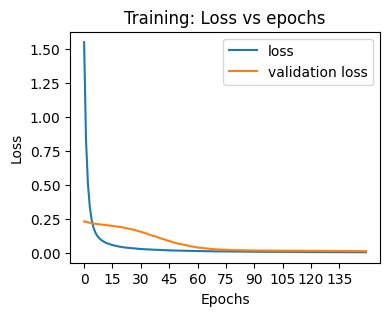

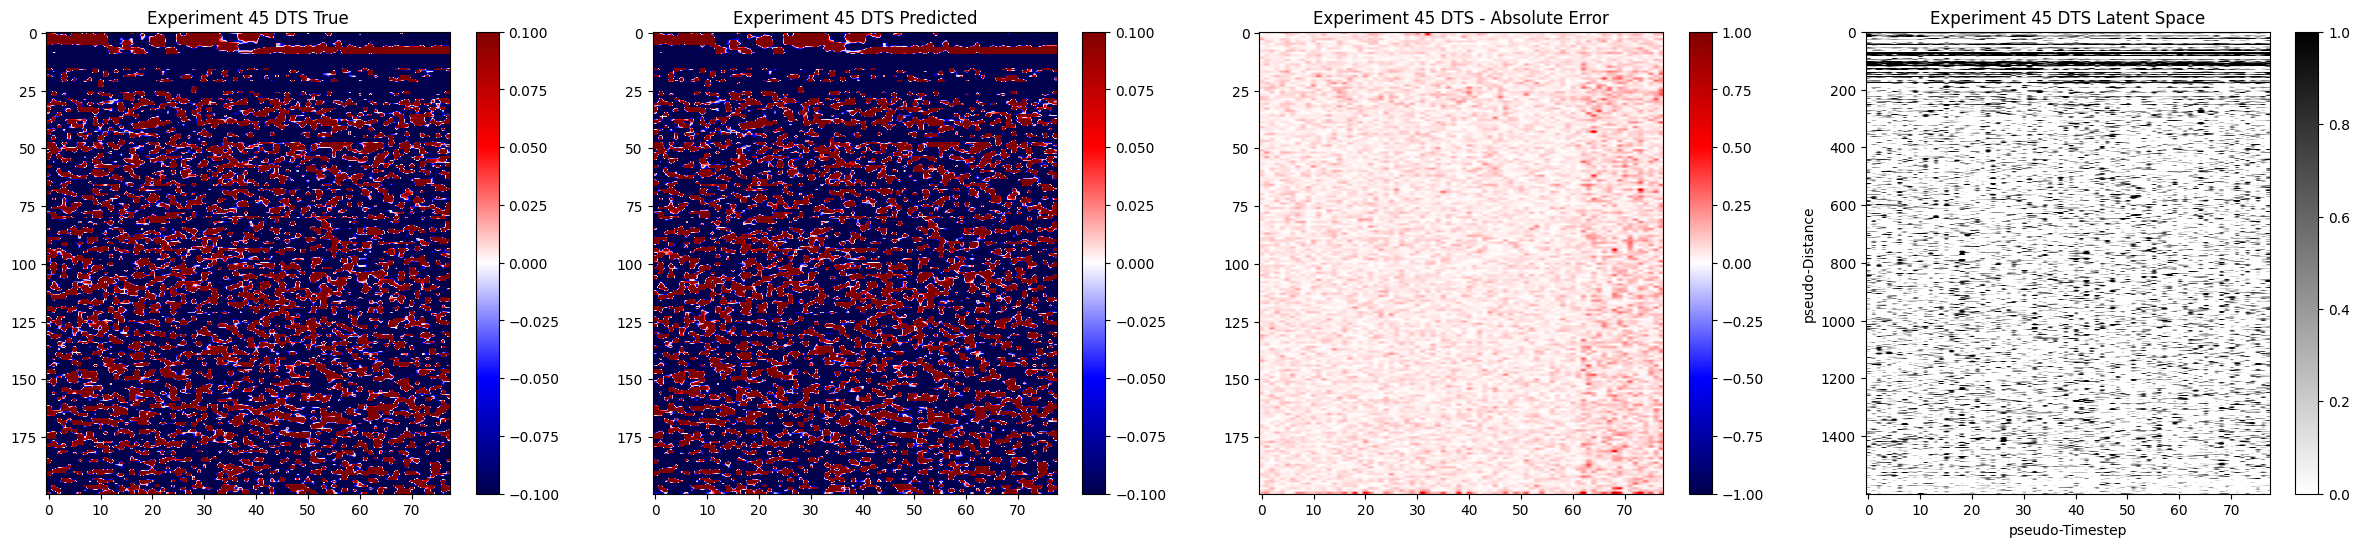

In [15]:
dts_m2m, dts_m2z = dts_Unet()
print('AutoEncoder # of parameters: {:,}'.format(dts_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(dts_m2z.count_params()))

dts_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_dts = dts_m2m.fit(dts45, dts45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_dts, figsize=(4,3))

dts45_pred = dts_m2m.predict(dts45).squeeze().astype('float64')
dts45_z = dts_m2z.predict(dts45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(dts45.squeeze().T, dts45_pred.T)))
print('MSE  = {:.3e}'.format(image_mse(dts45.squeeze().T, dts45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(dts45.squeeze().T, dts45_pred.T, data_range=2)))

plot_true_pred_z(dts45, dts45_pred, dts45_z, filenum='45 DTS')

***

MSE:  8.88e-09
SSIM: 1.000


Ridge()

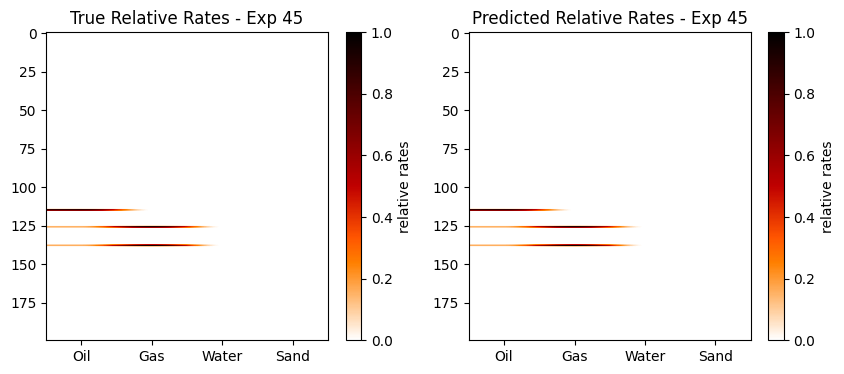

In [16]:
make_flowpred_from_dual_latent(das45_z, dts45_z, flow45, expnum='45', method=Ridge())

3/3 [==============================] - 0s 3ms/step
Shapes - z_DAS: (93, 25, 64) | z_DTS: (93, 25, 64)
MSE:  4.09e-09
SSIM: 1.000


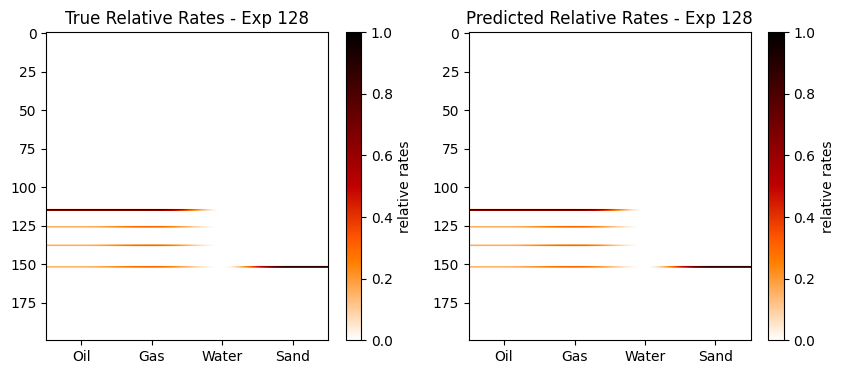

In [17]:
# Transfer Learning
transfer_learning_predictions(das128, dts128, flow128, das_m2z, dts_m2z, expnum='128', method=Ridge())

***
# END